## Keras-ImageDataGenerator

## 『本次練習內容』
#### 學習使用Keras-ImageDataGenerator 與 Imgae Augmentation 做圖像增強

## 『本次練習目的』
  #### 熟悉Image Augmentation的實作方法
  #### 瞭解如何導入Imgae Augmentation到原本NN架構中

## 第一 Part

C:\Users\andyhu\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\andyhu\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\andyhu\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique 

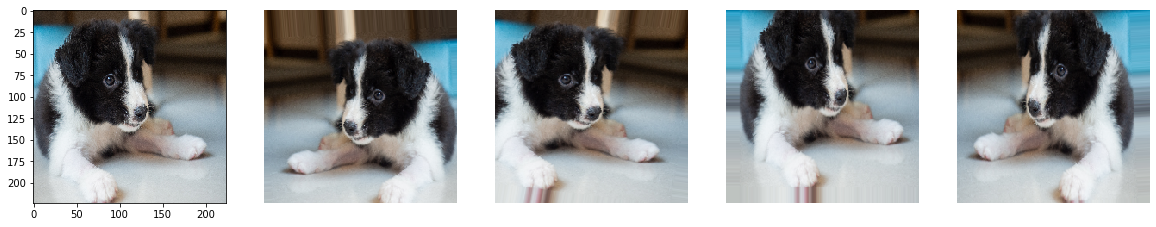

In [2]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

# define Augmentation, img_gen is a generator
img_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, rotation_range=10, 
                             width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                             horizontal_flip=True, vertical_flip=False, dtype=np.float32)
width = 224
height = 224
batch_size = 4

img = cv2.imread('img/Tano.JPG')  
img = cv2.resize(img, (width, height)) #  resize img to (224, 224)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 original is BGR，convert to RGB
img_origin = img.copy() # img_origin is RGB (224,224,3)
img = np.array(img, dtype=np.float32) # img is (224,224,3)
img_combine = np.array([img,img,img,img], dtype=np.uint8) # let (224,224,3) become to (4,224,224,3)
batch_gen = img_gen.flow(img_combine, batch_size=4)       # batch_gen is a iterator

assert next(batch_gen).shape==(batch_size, height, width, 3)

plt.figure(figsize=(20,10))
for batch,i in zip(batch_gen, [2,3,4,5]) :
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin) # image 1 : original image (RGB)
    
    plt.subplot(1, 5, i)   # image 2~5
    plt.imshow(batch[0, :, :, :].astype(np.uint8))  # batch_0
    plt.imshow(batch[1, :, :, :].astype(np.uint8))  # batch_1
    plt.imshow(batch[2, :, :, :].astype(np.uint8))  # batch_2
    plt.imshow(batch[3, :, :, :].astype(np.uint8))  # batch_3
    plt.axis('off')

## 示範如何導入ImageDataGenerator到Keras訓練中

In [2]:
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.datasets import cifar10          # for Downloading cifar10 data set 
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras import regularizers

input_shape = (64, 64, 3)

# Build CNN model
classifier = Sequential()

# 1st convolution layer(input layer) :
# Convolution2D(numbers of convolution kernel, kernel_row, kernel_column)
classifier.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape)) 
# output_shape=(None, 32, 32, 32)
classifier.add(MaxPooling2D(pool_size=(2,2))) 

# BatchNormalization : normalize the input

classifier.add(BatchNormalization()) #output_shape=(None, 16, 16, 32)

# 2nd convolution layer(hidden layer) 
classifier.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')) # output_shape=(None, 16, 16, 32)
classifier.add(MaxPooling2D(pool_size=(2,2)))  
# 2nd convolution layer:Total params(參數量)=(Kernel_row*column*channels+1)*Kernel numbers(kernel張數)=(3*3*32+1)*32=9248

# BatchNormalization : normalize the input
classifier.add(BatchNormalization())  #output_shape=(None, 8, 8, 32)

classifier.add(Flatten())  #output_shape=(None, 2048),

# FC layer (1st layer)
classifier.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
# output_shape=(None, 100)

# BatchNormalization : normalize the input
classifier.add(BatchNormalization()) # output_shape=(None, 100) 

# dropout rate : 50 %
classifier.add(Dropout(rate=0.5)) # output_shape=(None, 100)

# FC layer (2nd layer)
classifier.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(0.001))) 
# output_shape=(None, 100)

# BatchNormalization : normalize the input
classifier.add(BatchNormalization()) # output_shape=(None, 100) 

# dropout rate : 50 %
classifier.add(Dropout(rate=0.5))  # output_shape=(None, 100)

# FC layer (output layer) 
classifier.add(Dense(units=2, activation='softmax')) 
# output_shape=(None, 2)

## =============================================================

#Training Generator
train_data_gen = ImageDataGenerator(rescale = 2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
#Test Generator，只需要Rescale，不需要其他增強
test_data_gen = ImageDataGenerator(rescale = 1./255)

training_set = train_data_gen.flow_from_directory('img/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

test_set = test_data_gen.flow_from_directory('img/test_set',
                                            target_size = (64, 64),
                                            batch_size = 8,
                                            class_mode = 'categorical')

# compile( 優化器:optimizer='adam', 損失函數loss function:categorical_crossentropy, 模型評估指標:metrics=['accuracy'] )
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# EarlyStopping() 
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='test_loss', patience=8, verbose=1) # earlystop

# training model 
train_dataset = 8
test_dataset = 8
batch_size_1 = 4
classifier.fit_generator(training_set, steps_per_epoch = train_dataset / batch_size_1, epochs = 20,
                         validation_data = test_set, validation_steps = test_dataset / batch_size_1,
                         callbacks = [earlystop])

Found 8 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Epoch 1/20
2/2 [==============================] - 1s 626ms/step - loss: 0.7436 - accuracy: 0.7500 - val_loss: 0.9900 - val_accuracy: 0.5000
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 0.9184 - accuracy: 0.6250

C:\Users\andyhu\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `test_loss` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2/2 [==============================] - 1s 308ms/step - loss: 0.7108 - accuracy: 0.7500 - val_loss: 0.9981 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 1s 303ms/step - loss: 0.4702 - accuracy: 0.9375 - val_loss: 1.0110 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 1s 303ms/step - loss: 0.4884 - accuracy: 0.9375 - val_loss: 1.0077 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 1s 302ms/step - loss: 0.4441 - accuracy: 0.9375 - val_loss: 1.0047 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 1s 308ms/step - loss: 0.6160 - accuracy: 0.8125 - val_loss: 1.0081 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 1s 304ms/step - loss: 0.4165 - accuracy: 0.9375 - val_loss: 1.0101 - val_accuracy: 0.5000
Epoch 8/20
2/2 [==============================] - 1s 307ms/step - loss: 0.3870 - accuracy: 1.0000 - val_loss: 1.0104 - val_accuracy: 0.5000
Epoch 9/20
2/2 [===============

In [6]:
# 預測新照片
from keras.preprocessing import image as image_utils
# PIL image
test_image = image_utils.load_img('img/new_images/new_picture.jpg', target_size=(64, 64)) 
print(test_image)
test_image = image_utils.img_to_array(test_image) # image to array (3D), (64,64,3)
print(test_image.shape)
test_image = np.expand_dims(test_image, axis=0)   # 3D expand to 4D (1,64,64,3)
print(test_image.shape)


result = classifier.predict_on_batch(test_image)
result  # input picture which is dog, so dog get a higher probability

<PIL.Image.Image image mode=RGB size=64x64 at 0x229737D0978>
(64, 64, 3)
(1, 64, 64, 3)


array([[0.03259106, 0.96740896]], dtype=float32)

## 練習使用Image Augmentation
- 使用單項增強

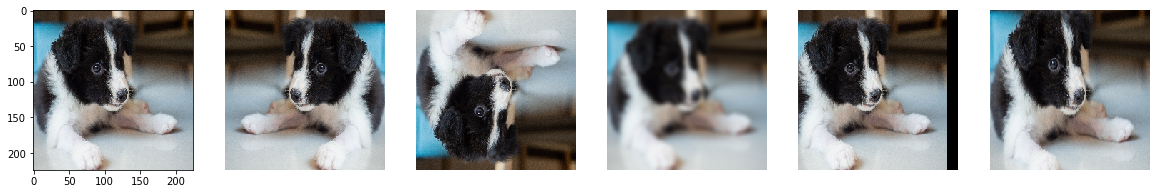

In [11]:
# 使用 imgaug 方式, 產生 augmentation
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('img/Tano.JPG')  
img = cv2.resize(img, (224,224)) # resize img to (224, 224)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 original is BGR，convert to RGB
img_origin = img.copy() # img_origin is RGB (224,224,3)
img = np.array(img, dtype=np.float32) # img is (224,224,3)

# np.random.randint(low value, high value, size, dtype)
images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8) # 創造一個5個樣本的 4D array,size=(5, 224, 224, 3)

flipper = iaa.Fliplr(1.0) # horizontal flip probability=1.0
images[0] = flipper.augment_image(img) 

vflipper = iaa.Flipud(0.4) # # vertical flip probability=0.4
images[1] = vflipper.augment_image(img) 

blurer = iaa.GaussianBlur(3.0)
images[2] = blurer.augment_image(img) # GaussianBlur (sigma of 3.0)

translater = iaa.Affine(translate_px={"x": -16}) # left shift 16 pixel, 
images[3] = translater.augment_image(img) 

scaler = iaa.Affine(scale={"y":(0.8, 1.2)}) # y axis scale rnge is 0.8 ~ 1.2
images[4] = scaler.augment_image(img)
# print(images.shape)  # (5, 224, 224, 3)

# image show
i=1
plt.figure(figsize=(20,20))
for image in images:
    plt.subplot(1, 6, 1)
    plt.imshow(img_origin.astype(np.uint8))  # image 1 : original image (RGB)
    
    plt.subplot(1, 6, i+1)  # image 2~6
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

## 第二Part

### 打包多種Augmentation
#### 請自行練習新增以及改變Augmentation內容
#### 可參考Github: https://github.com/aleju/imgaug

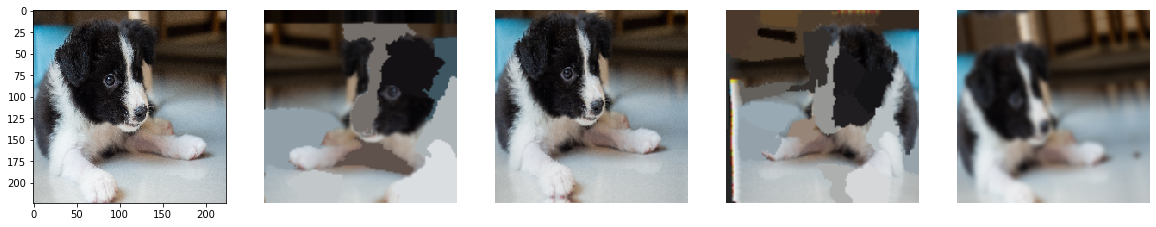

In [55]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

# read image
img = cv2.imread('img/Tano.JPG')  
img = cv2.resize(img, (224, 224)) # resize img to (224, 224)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 original is BGR，convert to RGB
img_origin = img.copy() # img_origin is RGB (224,224,3)
img = np.array(img, dtype=np.float32) # img is (224,224,3)
img_combine = np.array([img,img,img,img], dtype=np.uint8) 
# -> img_combine transfer to uint8 then to do seq.augment_images(img_combine)
# print(img_combine.shape)  # (4, 224, 224, 3)

# some images use 50% of Augmenters, other images use other 50% of Augmenters
sometimes = lambda aug: iaa.Sometimes(0.5, aug) 

# 包裝所要運用之圖像強化方式(imgaug augmentation),給每一張圖
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.4), 
    sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
        rotate=(-10, 10),
        shear=(-8, 8), 
        order=[0, 1], 
        cval=(0, 255),
        mode=ia.ALL 
    )),
    # convert images into their superpixel representation
    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), 
    sometimes(iaa.OneOf([
    iaa.GaussianBlur((0, 3.0)), # blur images 
                    iaa.AverageBlur(k=(1,3)), # blur image using local means with kernel sizes between 1 and 3
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                ])),
     sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
     sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))),     # emboss images
    ], random_order=True)

# Define the sequence of augmentation steps that will be applied to every image
images_aug = seq.augment_images(img_combine) # Image Augmentation
# print(images_aug.shape)  # (4, 224, 224, 3)

# image show
i=1
plt.figure(figsize=(20,20))
for image in images_aug:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin.astype(np.uint8))  # image 1 : original image (RGB)
    
    plt.subplot(1, 5, i+1)  # image 2~5
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

## 包裝自定義Augmentation 與 Imgaug Augmentation

In [56]:
from PIL import Image
import os
import pickle
import numpy as np
import cv2
import glob
import pandas as pd
import time
import random
import imgaug as ia
import imgaug.augmenters as iaa

# class : change brightness randomly    
class RandomBrightness(object):
    '''Function to randomly make image brighter or darker
    Parameters
    ----------
    delta: float
        the bound of random.uniform distribution
    '''
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image
    
# class : change contrast randomly
class RandomContrast(object):
    '''Function to strengthen or weaken the contrast in each image
    Parameters
    ----------
    lower: float
        lower bound of random.uniform distribution
    upper: float
        upper bound of random.uniform distribution
    '''
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower."
        assert lower >= 0, "contrast lower must be non-negative."
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image
    
# class : compose all of Augmentations
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image= t(image)
        return image

# class : function for the sequence of augmentation steps that will be applied to every image
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = self.sequence.augment_image(image)
      
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.4, aug) # applies the given augmenter in 40% of all cases
        
        # Define the sequence of augmentation steps that will be applied to every image
        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1),),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
            ], random_order=True)
        
        # compose the imgaug Augmentation and self definded Augmentation
        self.aug_pipeline = Compose([
            RandomBrightness(16),     # image brighter or darker
            RandomContrast(0.9, 1.1), # image contrast strengthen or weaken
            ImgAugSequence(img_seq),  # use the class ImgAugSequence()
        ])
        
    def __call__(self, image):
        image = self.aug_pipeline(image)
        return image

# build instance of class TrainAugmentations()
Augmenation = TrainAugmentations()

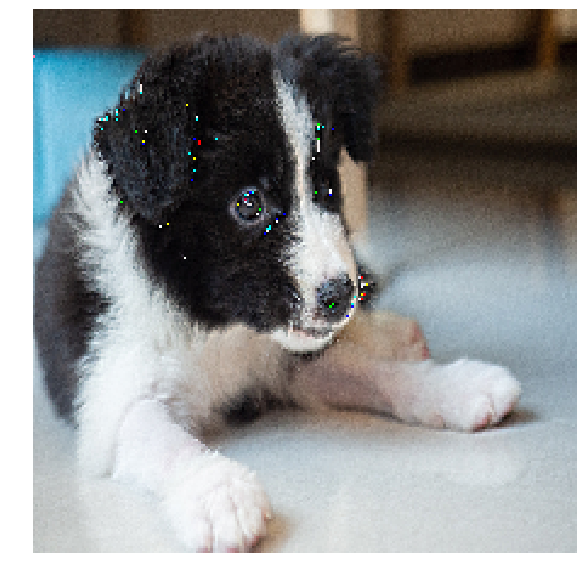

In [64]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

# read image
img = cv2.imread('img/Tano.JPG')  
img = cv2.resize(img, (224, 224)) # resize img to (224, 224)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 original is BGR，convert to RGB
img = np.array(img, dtype=np.float32)
# -> img transfer to float32 then to do Augmenation(img)

output = Augmenation(img) 
# print(output.shape) # 3D array (224, 224, 3)

# image show
plt.figure(figsize=(10,10))
for image in images_aug :    # images_au : 4D array (4, 224, 224, 3)
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')
    i+=1

## 鎖住隨機性-主要用在Semantic segmentation中

In [74]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask